In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast 
import math 
from sklearn.preprocessing import MinMaxScaler


In [25]:
df = pd.read_csv("/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/M4581_s1_Model_Data.csv")
df_test = "/Users/alexandranava/Desktop/Spores/M4576_s1/Analysis/V3/M4581_s1_Model_Data.csv"
import os

### Initializing

In [26]:
time_between_frames = 5
initial_exposure = 60
time_between_exposure = 120
num_frames = 276
columns_to_scale = ['INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION',
                     'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', "ELLIPSE ASPECT RATIO"]

columns_to_scale = ['INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION', 'ELLIPSE MINOR', 
                    'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', "ELLIPSE ASPECT RATIO"]

# Function to scale data
def scale_column(column):
    lists = column.apply(ast.literal_eval)
    flattened = np.concatenate(lists.values)
    scaler = MinMaxScaler()
    scaled_flattened = scaler.fit_transform(flattened.reshape(-1, 1)).flatten()
    scaled_lists = []
    start = 0
    for lst in lists:
        end = start + len(lst)
        scaled_lists.append(scaled_flattened[start:end].tolist())
        start = end
    return [str(lst) for lst in scaled_lists], scaler


#MAKE DF AND SCALE---
csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/M4581_s1_Model_Data.csv"
df = pd.read_csv(csv_path)
# scalers = {}
# for column in columns_to_scale:
#     df[column], scalers[column] = scale_column(df[column])

#df, scalers  = scale_csv_data(csv_path, columns_to_scale)
df = pd.read_csv(csv_path)
csv_path_test = csv_path = "/Users/alexandranava/Desktop/Spores/M4576_s2/M4576_s2_Model_Data.csv"
#df_test, df_test_scalers = scale_csv_data(csv_path_test, columns_to_scale)
#df_test = pd.read_csv(csv_path_test)


def calculate_exposure(num_frames, initial_exposure, time_between_exposure, time_between_frames) -> list[int]:
  frames_between_exposures = time_between_exposure/time_between_frames
  first_frame_exposure = initial_exposure/time_between_frames - 1

  print(f"first germinant exposure: {first_frame_exposure}")
  print(f"time between germinant exposures: {frames_between_exposures}")

  exposure_frames = [first_frame_exposure]

  while exposure_frames[-1] + frames_between_exposures < num_frames:
    exposure_frames.append(exposure_frames[-1] + frames_between_exposures)

  return first_frame_exposure, frames_between_exposures, exposure_frames

# function call 
first_frame_exposure, frames_between_exposures, germinant_exposures = calculate_exposure(num_frames, initial_exposure, time_between_exposure, time_between_frames)
print(f"Germinant exposures: {germinant_exposures}")

sample_germination_frames = [frame + 2 for frame in germinant_exposures]
def add_germination_index(df):
    GERMINATION: list[list] = df["GERMINATION"].apply(ast.literal_eval)
    germination_frames_list = GERMINATION.apply(lambda x: x.index(1))

    df["GERMINATION_INDEX"] = germination_frames_list
    #df["GERMINATION_INDEX"] = df["GERMINATION_INDEX"].astype(float)

add_germination_index(df)
#add_germination_index(df_test)
def add_germinant_exposures(df):
  EXPOSURE_COLUMN = [] # {exposure number: spores germinated with that exposure}

  for frame_number in df["GERMINATION_INDEX"]:
    exposure_count = math.floor((frame_number - first_frame_exposure)/frames_between_exposures) + 1
    EXPOSURE_COLUMN.append(exposure_count)
  df["GERMINANT_EXPOSURES"] = EXPOSURE_COLUMN
  return df

df = add_germinant_exposures(df)
#df_test = add_germinant_exposures(df_test)


first germinant exposure: 11.0
time between germinant exposures: 24.0
Germinant exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0]


### Plot three features, with a fourth as color

In [27]:
%matplotlib widget

from skspatial.objects import Points
from skspatial.objects import Plane
from skspatial.plotting import plot_3d
from sklearn.metrics import mean_squared_error



def size_stats_relationship(df, input_features, frames_considered):
  ellipse_minor = []
  area = []
  perimeter = []
  intensity = []
  germination = []
  exposure_until_germination = []

  for spore_i in range(len(df)):
    #exposure_until_germination += [exposure] * len(ast.literal_eval(df["GERMINATION"].iloc[spore_i]))
    germination += ast.literal_eval(df["GERMINATION"].iloc[spore_i])[:frames_considered]
    ellipse_minor += ast.literal_eval(df["ELLIPSE MINOR"].iloc[spore_i])[:frames_considered]
    area += ast.literal_eval(df["AREA"].iloc[spore_i])[:frames_considered]
    perimeter += ast.literal_eval(df["PERIMETER"].iloc[spore_i])[:frames_considered]
    intensity += ast.literal_eval(df["INTENSITY"].iloc[spore_i])[:frames_considered]

  ellipse_minor_dormant = []
  area_dormant = []
  perimeter_dormant = []
  intensity_dormant = []

  for i, germ_status in enumerate(germination):
    if germ_status < 1:
      ellipse_minor_dormant.append(ellipse_minor[i])
      area_dormant.append(area[i])
      perimeter_dormant.append(perimeter[i])
      intensity_dormant.append(intensity[i])

  points = Points(np.column_stack((ellipse_minor_dormant, area_dormant, perimeter_dormant)))
  plane = Plane.best_fit(points)
  distances = np.array([plane.distance_point(point) for point in points])

  # Calculate RMSE
  rmse = np.sqrt(mean_squared_error(np.zeros_like(distances), distances))
  print(f"RMSE of points to plane: {rmse}")
  print(plane)

  fig, ax = plot_3d(
      points.plotter(c=intensity_dormant, s=10, depthshade=False, cmap='viridis'),
      plane.plotter(alpha=0.1, lims_x=(-0.4, 0.4), lims_y=(-0.4, 0.4)),
  )
  ax.set_xlabel("Ellipse Minor")
  ax.set_ylabel("Area")
  ax.set_zlabel("Perimeter")

  cbar = plt.colorbar(ax.collections[0], ax=ax, shrink = 0.5, pad = 0.15)
  cbar.set_label("Intensity")

  #plt.title(f"Physiological Features over Initial {frames_considered} Frames")
  plt.title(f"Physiological Features During Dormancy")
  plt.show()

frames_considered = 289
#size_stats_relationship(df, ["ELLIPSE MINOR", "AREA", "PERIMETER", "INTENSITY", "GERMINATION"], frames_considered)

### Minimize $ ||\text{Intensity} - (a*\text{Area}^2 + b*\text{Perimeter}^2 + c*\text{Ellipse Minor}^2)|| $

In [28]:
%matplotlib inline
from scipy.optimize import minimize


def func(coef, x, y, z, m):
    a = coef[0]
    b = coef[1]
    c = coef[2]
    d = coef[3]
    e = coef[4]
    f = coef[5]
    return np.linalg.norm(m - a*x**2 + b*y**2 + c*z**2 + d*x + e*y + f*z)

def fit_4d(df):
  fit_last_frame_index = 30
  fit_first_frame_index = 8
  #fitting m = ax^2 + by^2 + cz^2
  ellipse_minor_dormant = []
  area_dormant = []
  perimeter_dormant = []
  intensity_dormant = []

  for spore_i in range(len(df)):
    germination_frame = df["GERMINATION_INDEX"].iloc[spore_i]
    
    ellipse_minor_dormant += ast.literal_eval(df["ELLIPSE MINOR"].iloc[spore_i])[fit_first_frame_index:germination_frame]
    area_dormant += ast.literal_eval(df["AREA"].iloc[spore_i])[fit_first_frame_index:germination_frame]
    perimeter_dormant += ast.literal_eval(df["PERIMETER"].iloc[spore_i])[fit_first_frame_index:germination_frame]
    intensity_dormant += ast.literal_eval(df["INTENSITY"].iloc[spore_i])[fit_first_frame_index:germination_frame]

  x = np.array(area_dormant)
  y = np.array(perimeter_dormant)
  z = np.array(ellipse_minor_dormant)
  m = np.array(intensity_dormant)
  

  res = minimize(func, [1, 1, 1,1,1,1], args=(x, y, z, m))
  a, b, c, d, e, f = res.x
  return a, b, c, d, e, f, x, y, z, m


a, b, c, d, e, f, x, y, z, m = fit_4d(df)
print(f"a = {a}, b = {b}, c = {c}")


a = 0.0004504658710585894, b = 0.010047108948875318, c = -0.33797567229731346


In [29]:
def model_intensity(a,b,c, d,e,f,area, perimeter, ellipse_minor):
  return a*area**2 + b*perimeter**2 + c*ellipse_minor**2 + d * area + e*perimeter + f*ellipse_minor 

<Figure size 640x480 with 0 Axes>

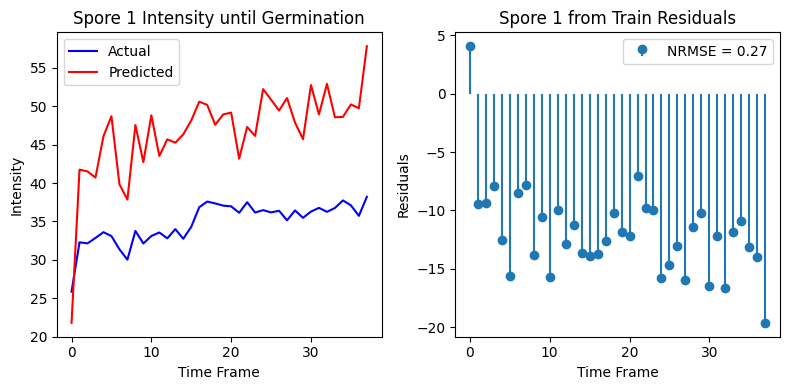

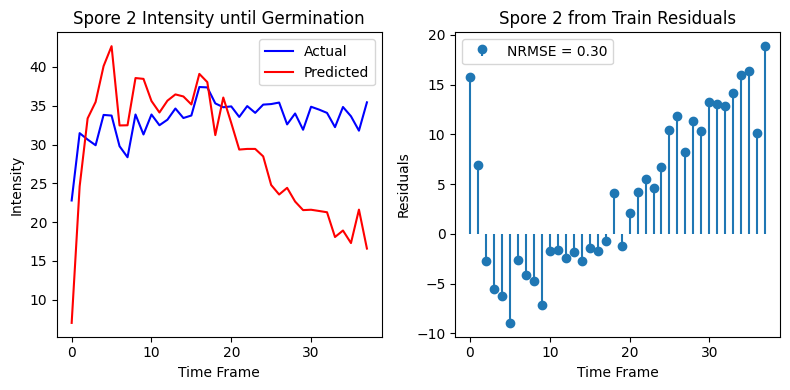

In [30]:
plt.clf()

def calculate_normalized_rmse(list1, list2, avg_pred_intensity):
    list1 = np.array(list1)
    list2 = np.array(list2)
    rmse = np.sqrt(np.mean((list1 - list2) ** 2))
    normalized_rmse = rmse/avg_pred_intensity
    return normalized_rmse
  
def run_model(experiment, df):
 rmses = []
 residuals = []
 for spore_row in range(len(df)):

  spore_data = df.iloc[spore_row][["AREA", "PERIMETER", "ELLIPSE MINOR", "INTENSITY"]]
  germination_frame = df["GERMINATION_INDEX"].iloc[spore_row]
  
  spore_intensity = ast.literal_eval(spore_data["INTENSITY"])
  spore_area = ast.literal_eval(spore_data["AREA"])
  spore_perimeter = ast.literal_eval(spore_data["PERIMETER"])
  spore_minor = ast.literal_eval(spore_data["ELLIPSE MINOR"])
  pred_intensity = [model_intensity(a,b,c,d,e,f,spore_area[t], spore_perimeter[t], spore_minor[t]) for t in range(len(spore_intensity))]
  # Create a figure with two subplots side by side
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

  # Plot actual vs predicted intensity on the left subplot
  #ax1.scatter(pred_intensity[:germination_frame], spore_intensity[:germination_frame], label="Actual", color="blue")
  ax1.plot(range(germination_frame), spore_intensity[:germination_frame], label="Actual", color="blue")
  ax1.plot(range(germination_frame), pred_intensity[:germination_frame], label="Predicted", color="red")
  ax1.set_title(f"Spore {spore_row + 1} Intensity until Germination")
  ax1.set_xlabel("Time Frame")
  #ax1.set_ylim(0, 0.8)
  ax1.set_ylabel("Intensity")
  ax1.legend()

  # Calculate RMSE
  avg_pred_intensity = np.average(pred_intensity[:germination_frame])
  rmse = calculate_normalized_rmse(pred_intensity[:germination_frame], spore_intensity[:germination_frame], avg_pred_intensity)
  rmses.append(rmse)

  # Plot residuals on the right subplot
  residuals = np.array(spore_intensity[:germination_frame]) - np.array(pred_intensity[:germination_frame])
  ax2.stem(range(len(residuals)), residuals, basefmt=" ", label = f"NRMSE = {rmse:.2f}")
  #ax2.set_ylim(min(df["INTENSITY"]), max(df["INTENSITY"]))
  ax2.set_title(f"Spore {spore_row + 1} from {experiment} Residuals")
  ax2.set_xlabel("Time Frame")
  ax2.set_ylabel("Residuals")
  ax2.legend()

  # Show the combined plots
  plt.tight_layout()
  plt.show()
 return rmses 

predicted_rmses = run_model("Train", df)
#predicted_rmses_test = run_model("Test", df_test)

In [15]:
# print(f"average nrmse (Train): {np.average(predicted_rmses)}")
# print(f"average nrmse (Test): {np.average(predicted_rmses_test)}")

# rmse_data = {
#     "Experiment": ["Train"] * len(predicted_rmses) + ["Test"] * len(predicted_rmses_test),
#     "NRMSE": np.concatenate([predicted_rmses, predicted_rmses_test])
# }
# rmse_df = pd.DataFrame(rmse_data)

# fig, ax = plt.subplots()
# sns.boxplot(data=rmse_df, x="Experiment", y="NRMSE", ax=ax, hue = "Experiment", palette = "pastel")
# ax.set_ylabel("NRMSE (Predicted - Actual Intensity)")
# ax.set_title("NRMSEs of Individual Spores until Germination")
# plt.show()




### Compute Area and Perimeter given Ellipse Minor and Major

In [16]:
def compute_perimeter(minor, major):
  a = major
  b = minor
  perimeter = np.pi * (3 * (a + b) - np.sqrt((3 * a + b) * (a + 3 * b))) + 2

  return perimeter
def compute_area(minor, major):
  area = np.pi * minor * major - 10
  return area

In [17]:
def minor_major(df):
 plt.figure(figsize=(10, 8))  # Create a new figure

 for spore_row in range(len(df)):
   
   plt.figure(figsize=(3, 2))  # Create a new figure
   spore_data = df.iloc[spore_row][["ELLIPSE MINOR", "ELLIPSE MAJOR"]]
   germination_frame = df["GERMINATION_INDEX"].iloc[spore_row]

   spore_minor = ast.literal_eval(spore_data["ELLIPSE MINOR"])
   spore_major = ast.literal_eval(spore_data["ELLIPSE MAJOR"])

  
   sns.lineplot(x = range(germination_frame), y = spore_minor[:germination_frame], label = "Minor", color = "red")
   sns.lineplot(x = range(germination_frame), y = spore_major[:germination_frame], label = "Major", color = "blue")

#minor_major(df)

In [18]:
def unscale_column(scaled_column, scaler):
    lists = scaled_column.apply(ast.literal_eval)
    flattened = np.concatenate(lists.values)
    unscaled_flattened = scaler.inverse_transform(flattened.reshape(-1, 1)).flatten()
    unscaled_lists = []
    start = 0
    for lst in lists:
        end = start + len(lst)
        unscaled_lists.append(unscaled_flattened[start:end].tolist())
        start = end
    return [str(lst) for lst in unscaled_lists]

#To unscale:
# columns_to_unscale = ["PERIMETER", "AREA", "ELLIPSE MINOR", "ELLIPSE MAJOR"]
# for column in columns_to_unscale:
#     df[column] = unscale_column(df[column], scalers[column])

simulating 54 spores...


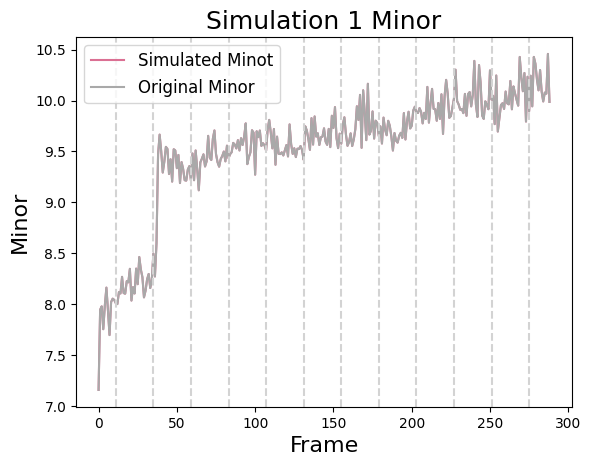

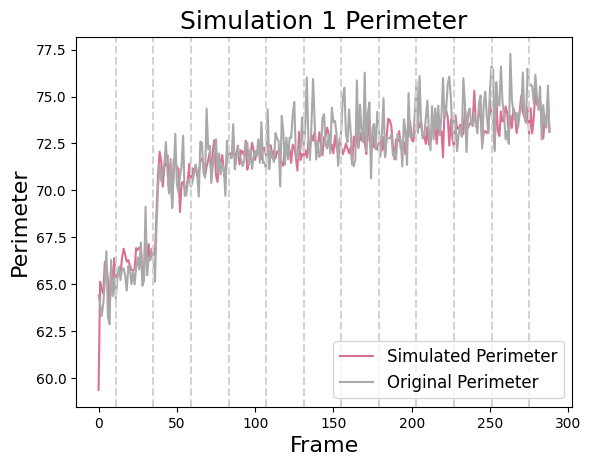

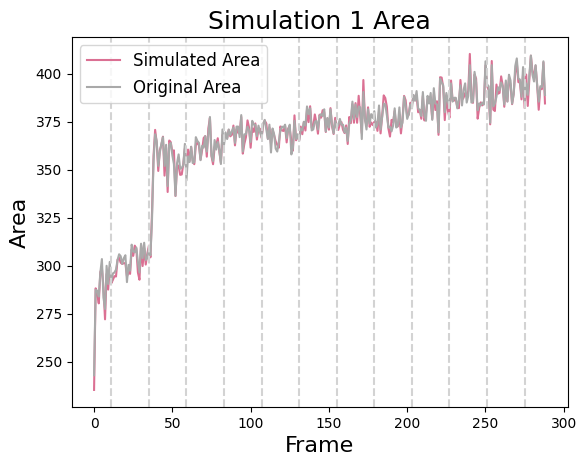

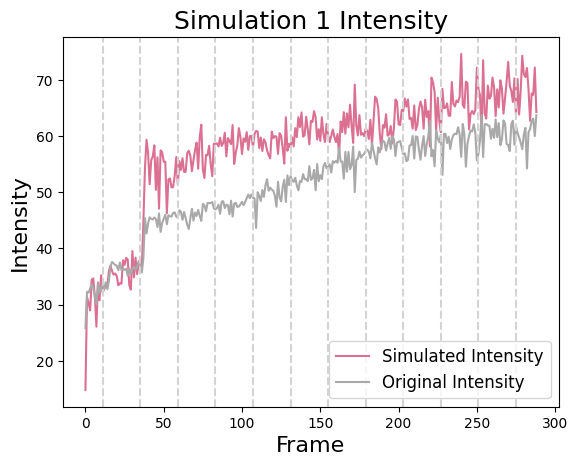

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_99561/1182069602.py:132: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_simulation_dataframe = pd.concat([model_simulation_dataframe, simulated_spore_data], ignore_index=True)


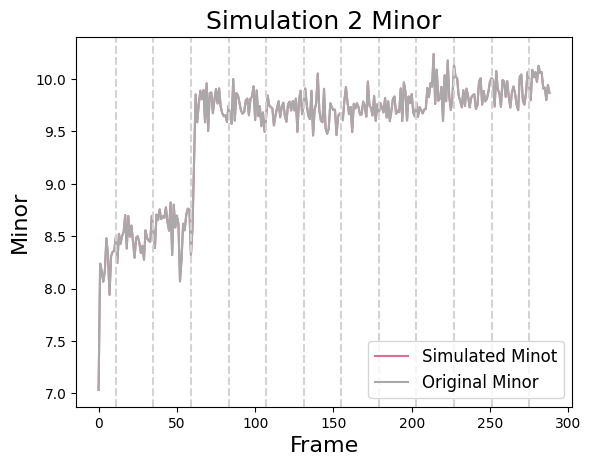

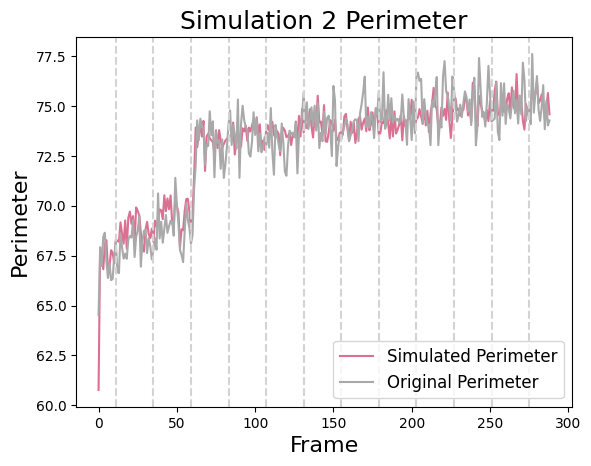

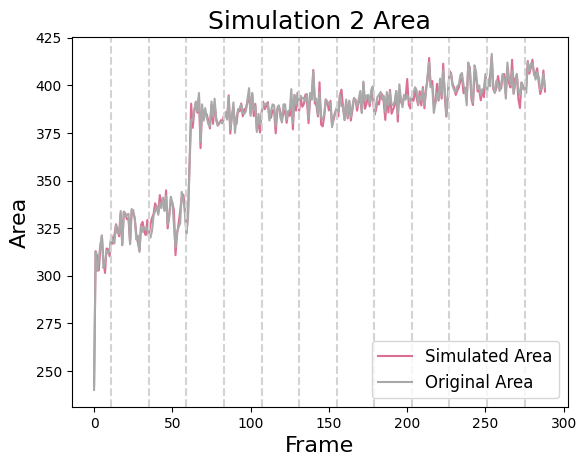

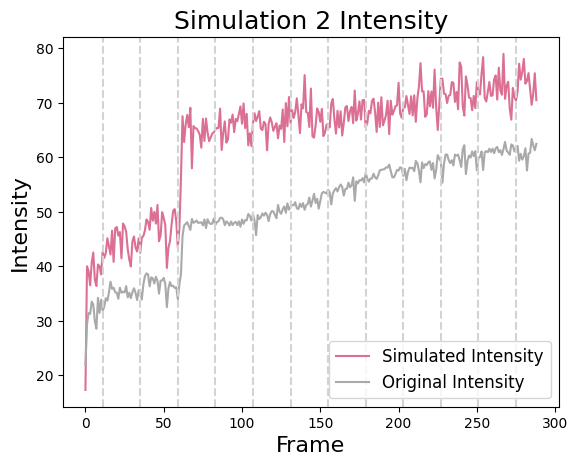

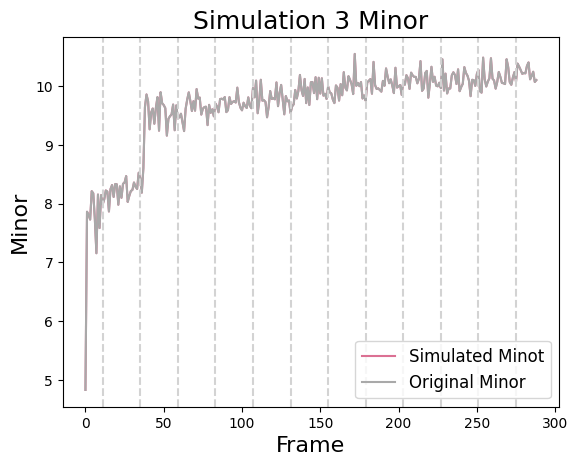

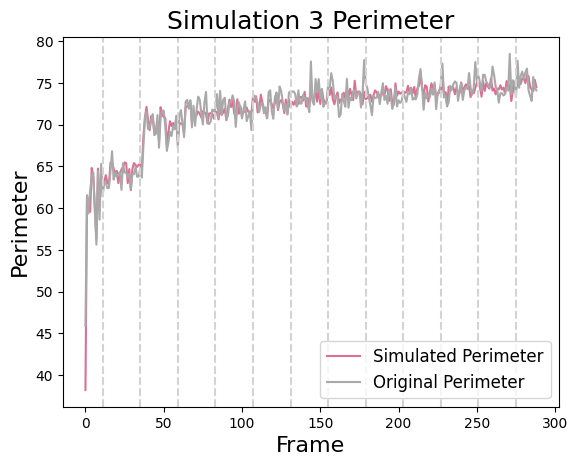

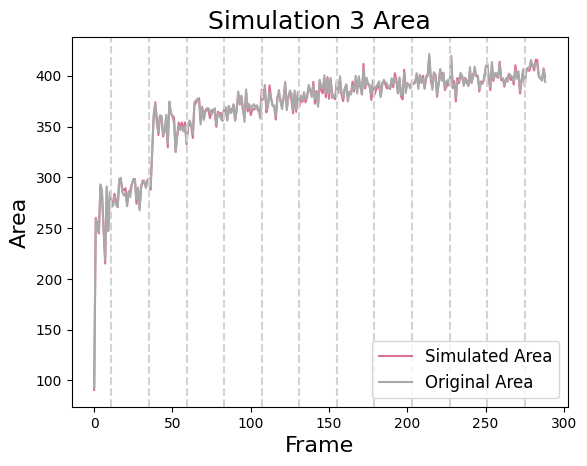

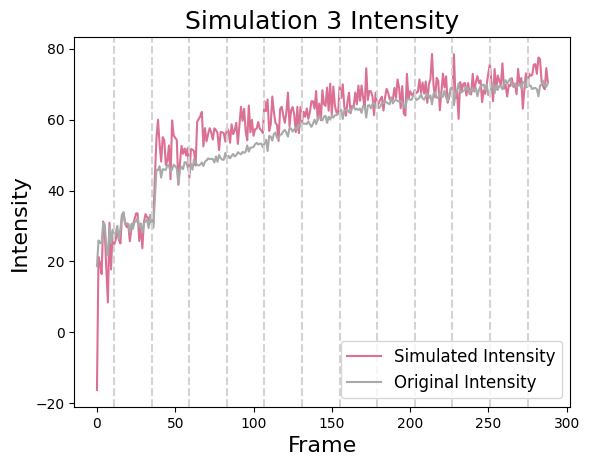

In [23]:
def simulate_data(df, ellipse_minor_changes, ellipse_major_changes, write_data =1):
  simulations_folder = "/Users/alexandranava/Desktop/Spores/GerminationPrediction/Model_Analysis/Simulation_Data/"
  experiment = "M4581_s1"

  model_simulation_dataframe = pd.DataFrame(columns=["SPORE_ID", "AREA", "PERIMETER", "FRAME", "GERMINANT_EXPOSURE", "GERMINATION"])


  simulated_spore_changes = len(ellipse_minor_changes)
  total_simulations = len(df)*simulated_spore_changes
  simulation_number = 0
  print(f"simulating {total_simulations} spores...")

  for spore_row in range(len(df)):
    if spore_row == 1:
      continue
    
    spore_data = df.iloc[spore_row]
    original_spore_data = {
        "SPORE_ID": [spore_row] * len(ast.literal_eval(spore_data["ELLIPSE MINOR"])),
        "FRAME": list(range(len(ast.literal_eval(spore_data["ELLIPSE MINOR"])))),
        "INTENSITY": ast.literal_eval(spore_data["INTENSITY"]),
        "AREA": ast.literal_eval(spore_data["AREA"]),
        "PERIMETER": ast.literal_eval(spore_data["PERIMETER"]),
        "ELLIPSE_MINOR": ast.literal_eval(spore_data["ELLIPSE MINOR"]),
        "ELLIPSE_MAJOR": ast.literal_eval(spore_data["ELLIPSE MAJOR"])
    }



    spore_minor = ast.literal_eval(spore_data["ELLIPSE MINOR"])
    spore_major = ast.literal_eval(spore_data["ELLIPSE MAJOR"])

    germinant_exposure = ast.literal_eval(spore_data["GERMINANT EXPOSURE"])
    germination = ast.literal_eval(spore_data["GERMINATION"])

    #iterate through original spores 
    for spore_sim_idx in range(simulated_spore_changes):
      num_timesteps = len(spore_minor)
      ellipse_minor_change = ellipse_minor_changes[spore_sim_idx]
      ellipse_major_change = ellipse_major_changes[spore_sim_idx]

      simulation_number_col = []
      simulated_minor = []
      simulated_major = []
      simulated_perimeter = []
      simulated_area = []
      simulated_intensity = []
      frames = []


      #add physiological features to kist for each timestep of original spore 
      for t in range(num_timesteps):
        #read in changed minor
        simulated_minor_t = spore_minor[t] + ellipse_minor_change 
        simulated_minor.append(simulated_minor_t)
        #read in changed major
        simulated_major_t = spore_major[t] + ellipse_major_change
        simulated_major.append(simulated_major_t)
        #calculate perimeter
        simulated_perimeter_t = compute_perimeter(simulated_minor_t, simulated_major_t)
        simulated_perimeter.append(simulated_perimeter_t)
        #calculate_area
        simulated_area_t = compute_area(simulated_minor_t, simulated_major_t)
        simulated_area.append(simulated_area_t)
        #calculate intensity
        simulated_intensity_t = model_intensity(a, b, c, d, e, f, simulated_area_t, simulated_perimeter_t, simulated_minor_t) * (3/4)
        simulated_intensity.append(simulated_intensity_t)
        #keep track of simulation idx 
        simulation_number_col.append(simulation_number)
        frames.append(t)



      simulation_number += 1
      simulated_spore_data = {"SPORE_ID": simulation_number_col,
                              "AREA": simulated_area,
                              "PERIMETER": simulated_perimeter,
                              "ELLIPSE_MINOR": simulated_minor,
                              "ELLIPSE_MAJOR": simulated_major,
                              "INTENSITY": simulated_intensity,
                              "FRAME": frames,
                              "GERMINATION": germination,
                              "GERMINANT_EXPOSURE": germinant_exposure,
                              "X_POSITION": [0] * num_timesteps,
                              "Y_POSITION": [0] * num_timesteps
                              }
      
      simulated_spore_data = pd.DataFrame(simulated_spore_data)

      if simulation_number < 4:
        #Ellipse Minor
        sns.lineplot( x = "FRAME", y = "ELLIPSE_MINOR", data = simulated_spore_data, label = "Simulated Minot", color = "palevioletred")
        sns.lineplot(x="FRAME", y="ELLIPSE_MINOR", data=pd.DataFrame(original_spore_data), label='Original Minor', color = "darkgrey")
        plt.title(f"Simulation {simulation_number} Minor", fontsize = 18)
        plt.xlabel("Frame", fontsize = 16)
        plt.ylabel("Minor", fontsize = 16)
        for exposure in germinant_exposures:
          plt.axvline(exposure, color = "lightgrey", linestyle = "--")
        plt.legend(loc = "best", fontsize = 12)
        plt.show()
        #Perimeter
        sns.lineplot( x = "FRAME", y = "PERIMETER", data = simulated_spore_data, label = "Simulated Perimeter", color = "palevioletred")
        sns.lineplot(x="FRAME", y="PERIMETER", data=pd.DataFrame(original_spore_data), label='Original Perimeter', color = "darkgrey")
        plt.title(f"Simulation {simulation_number} Perimeter", fontsize = 18)
        plt.xlabel("Frame", fontsize = 16)
        plt.ylabel("Perimeter", fontsize = 16)
        for exposure in germinant_exposures:
          plt.axvline(exposure, color = "lightgrey", linestyle = "--")
        plt.legend(loc = "best", fontsize = 12)
        plt.show()
        #Area
        sns.lineplot( x = "FRAME", y = "AREA", data = simulated_spore_data, label = "Simulated Area", color = "palevioletred")
        sns.lineplot(x="FRAME", y="AREA", data=pd.DataFrame(original_spore_data), label='Original Area', color = "darkgrey")
        plt.title(f"Simulation {simulation_number} Area", fontsize = 18)
        plt.xlabel("Frame", fontsize = 16)
        plt.ylabel("Area", fontsize = 16)
        for exposure in germinant_exposures:
          plt.axvline(exposure, color = "lightgrey", linestyle = "--")
        plt.legend(loc = "best", fontsize = 12)
        plt.show()
        #Intensity
        sns.lineplot( x = "FRAME", y = "INTENSITY", data = simulated_spore_data, label = "Simulated Intensity", color = "palevioletred")
        sns.lineplot(x="FRAME", y="INTENSITY", data=pd.DataFrame(original_spore_data), label='Original Intensity', color = "darkgrey")
        plt.xlabel("Frame", fontsize = 16)
        plt.ylabel("Intensity", fontsize = 16)
        for exposure in germinant_exposures:
          plt.axvline(exposure, color = "lightgrey", linestyle = "--")
        plt.title(f"Simulation {simulation_number} Intensity", fontsize = 18)
        plt.legend(loc = "best", fontsize = 12)
        plt.show()

      model_simulation_dataframe = pd.concat([model_simulation_dataframe, simulated_spore_data], ignore_index=True)
  
  if write_data == 1:
    simulation_version = 0 
    simulation_written = 0

    while simulation_written == 0:
      simulation_path = f"{simulations_folder}simulation_v{simulation_version}.csv"
      if os.path.exists(simulation_path):
          simulation_version += 1
      else:
        model_simulation_dataframe.to_csv(simulation_path)

        #write simulation info 
        simulation_info_df = {
          "Experiment": ["M4581_s1"],
          "Ellipse_Minor_Changes": [ellipse_minor_changes],
          "Ellipse_Major_Changes": [ellipse_major_changes]  
        }

        simulation_info_df = pd.DataFrame(simulation_info_df)
        simulation_info_path = f"{simulations_folder}simulation_v{simulation_version}_info.csv"
        simulation_info_df.to_csv(simulation_info_path)
        simulation_written = 1
  return 
simulate_data(df, [0], [0])